
# How to check all possible targets binding sites against off-target binding sites in whole transcriptome
We have a target mRNA that we want to bind with RNA binding proteins. To design these pumby proteins we need to select binding sites on our target mRNA which are very unique, i.e. ideally dont occure elsewhere the transcriptome. Currently this programm is being tested with random numeric data, instead of character sequences, but that is ok since every 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import pandas as pd
from time import time

In [2]:

@njit
def sc_jit(seq, ref):
    '''A fast sequence comparison of a short query sequence (seq) against a larger reference (ref).
    Returns the number of matches for every position the sort sequence could bind to the larger one. Consideres only full overlap binding, i.e. no overhangs '''

    n = len(ref) - len(seq) + 1
    if n<1: print("sc_jit: wrong argument order")
    cv = np.zeros(n, dtype=np.int8) 
    for i in range(n):
        count = 0
        for j in range(len(seq)):
            if ref[i + j] == seq[j]:
                count += 1
        cv[i] = count
    return cv
    
def random_seq(size):
    return ''.join(np.array(["A", "C", "G", "T"])[np.random.randint(low = 0, high = 4, size = size)])

sc_jit(random_seq(10), random_seq(10));    # call it once for numba to compile the function

# Search off-target binding-sites on single transcript
- as we are searching for binding sites in the transcriptome, we'd ideally find as few as possible, to avoid unwanted side-effects.

In [3]:
query = pd.Series({"SEQ_NAME": "rand_query",      "SEQUENCE": random_seq(size = 12)})       # the query sequence i.e. candidate binding sequence for the target 
ref   = pd.Series({"SEQ_NAME": "rand_transcript", "SEQUENCE": random_seq(size = 10**3)})    # The reference to check against, i.e. a transcript from the transcriptome in this example

{'mismatch_eq_0': np.int64(0),
 'mismatch_eq_1': np.int64(0),
 'mismatch_eq_2': np.int64(0),
 'boltzman_factor': np.float16(0.3667)}

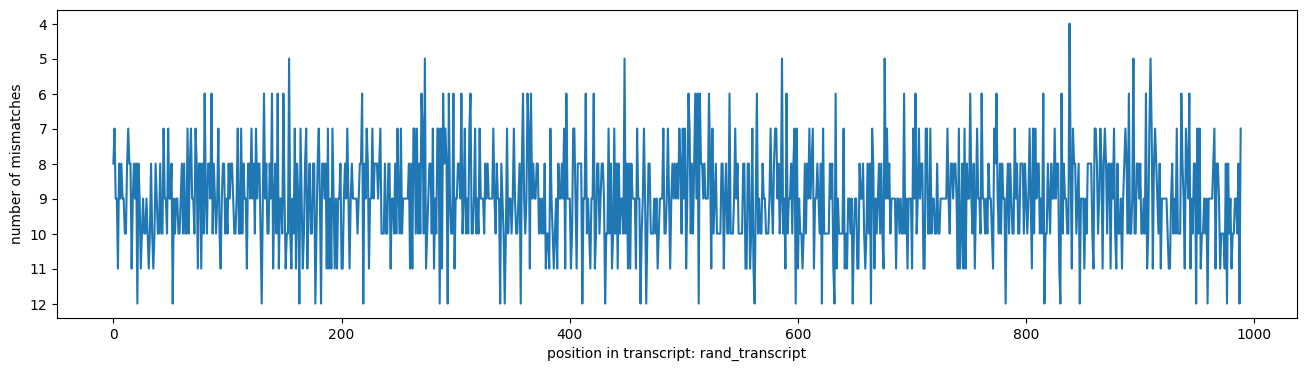

In [4]:
mm = len(query.SEQUENCE)-sc_jit(query.SEQUENCE.encode("utf-8"), ref.SEQUENCE.encode("utf-8")) # number of mismatches per position

sc_results = {}                                        # summarize the possible binding sites of the query sequence against one reference sequence i.e. a transcript from the transcriptome
sc_results["mismatch_eq_0"] = (mm==0).sum()            # number of idential matches
sc_results["mismatch_eq_1"] = (mm==1).sum()            # number of matches with 1 mismatch
sc_results["mismatch_eq_2"] = (mm==2).sum()            # number of matches with 2 mistmatches
sc_results["boltzman_factor"] = np.sum(np.exp(-mm))    # a prediction of how likely the query sequence would bind to the reference. # Currently the boltzman_factor for a perfect match is 1, if therefore this predicted boltzman_factor is smaller than 1 than it is more likly to bind to the specific RNA, while if it is larger than one it is more likely to bind to the background transcriptom ""
        
plt.figure(figsize=(16, 4))
plt.plot(mm)
plt.gca().invert_yaxis()
plt.ylabel("number of mismatches")
plt.xlabel(f"position in transcript: {ref.SEQ_NAME}")
sc_results

# Search off-target binding-sites in a list of transcripts

In [5]:
reference_dataset = pd.DataFrame([{"SEQ_NAME": f"random_transcript_#{i}", "SEQUENCE": random_seq(size = 10**3)} for i in range(10000)])    # The reference to check against, i.e. a transcript from the transcriptome in this example
query             = pd.Series(    {"SEQ_NAME": "random_candidate",        "SEQUENCE": random_seq(size = 12)})                              #  Binding Site Candidate
plot = True

In [6]:
###  Search for binding sites in reference dataset  
detailed_query_results = pd.DataFrame()                    # initialize a dataset to store the results of comparing query sequence with every reference i.e. every transcript in the transcriptome
for i, ref in reference_dataset.iterrows():                # iterate over all reference sequences. 
    
    mm = len(query.SEQUENCE)-sc_jit(query.SEQUENCE.encode("utf-8"), ref.SEQUENCE.encode("utf-8")) # number of mismatches per position # utf8 encoding of strings to integers speeds up the comparison for some reason
    sc_row = {"SEQ_NAME": ref.SEQ_NAME}                    # summarize the possible binding sites of the query sequence against one reference sequence i.e. a transcript from the transcriptome
    sc_row["identical match"] = (mm==0).sum()              # number of idential matches
    sc_row["1nt mismatch"]    = (mm==1).sum()              # number of sites with 1 mismatch
    sc_row["2nt mismatch"]    = (mm==2).sum()              # number of sites with 2 mistmatches
    sc_row["boltzman factor"] = np.sum(np.exp(-mm))        # a prediction of how likely the query sequence would bind to the reference. Currently the boltzman_factor for a perfect match is 1, if therefore this predicted boltzman_factor is smaller than 1 than it is more likly to bind to the specific RNA, while if it is larger than one it is more likely to bind to the background transcriptom ""
    
    detailed_query_results = pd.concat([detailed_query_results, pd.DataFrame([sc_row])], ignore_index=True) # add the results for this transcript to the dataset

detailed_query_results

C:\Users\T3D\miniforge3\lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,SEQ_NAME,identical match,1nt mismatch,2nt mismatch,boltzman factor
0,random_transcript_#0,0,0,0,0.468018
1,random_transcript_#1,0,0,0,0.446289
2,random_transcript_#2,0,0,0,0.455322
3,random_transcript_#3,0,0,0,0.426025
4,random_transcript_#4,0,0,0,0.447754
...,...,...,...,...,...
9995,random_transcript_#9995,0,0,0,0.444824
9996,random_transcript_#9996,0,0,0,0.402100
9997,random_transcript_#9997,0,0,0,0.467773
9998,random_transcript_#9998,0,0,0,0.510742


{'SEQUENCE': 'CTCTGTTTAATC',
 'identical match_max': np.int64(0),
 'identical match_sum': np.int64(0),
 'identical match_score100': np.float64(0.5),
 '1nt mismatch_max': np.int64(1),
 '1nt mismatch_sum': np.int64(30),
 '1nt mismatch_score100': np.float64(0.5000306993323664),
 '2nt mismatch_max': np.int64(2),
 '2nt mismatch_sum': np.int64(348),
 '2nt mismatch_score100': np.float64(0.5003560383089143),
 'boltzman factor_max': np.float16(0.9263),
 'boltzman factor_sum': np.float16(4430.0),
 'boltzman factor_score100': np.float64(0.5052190531626706)}

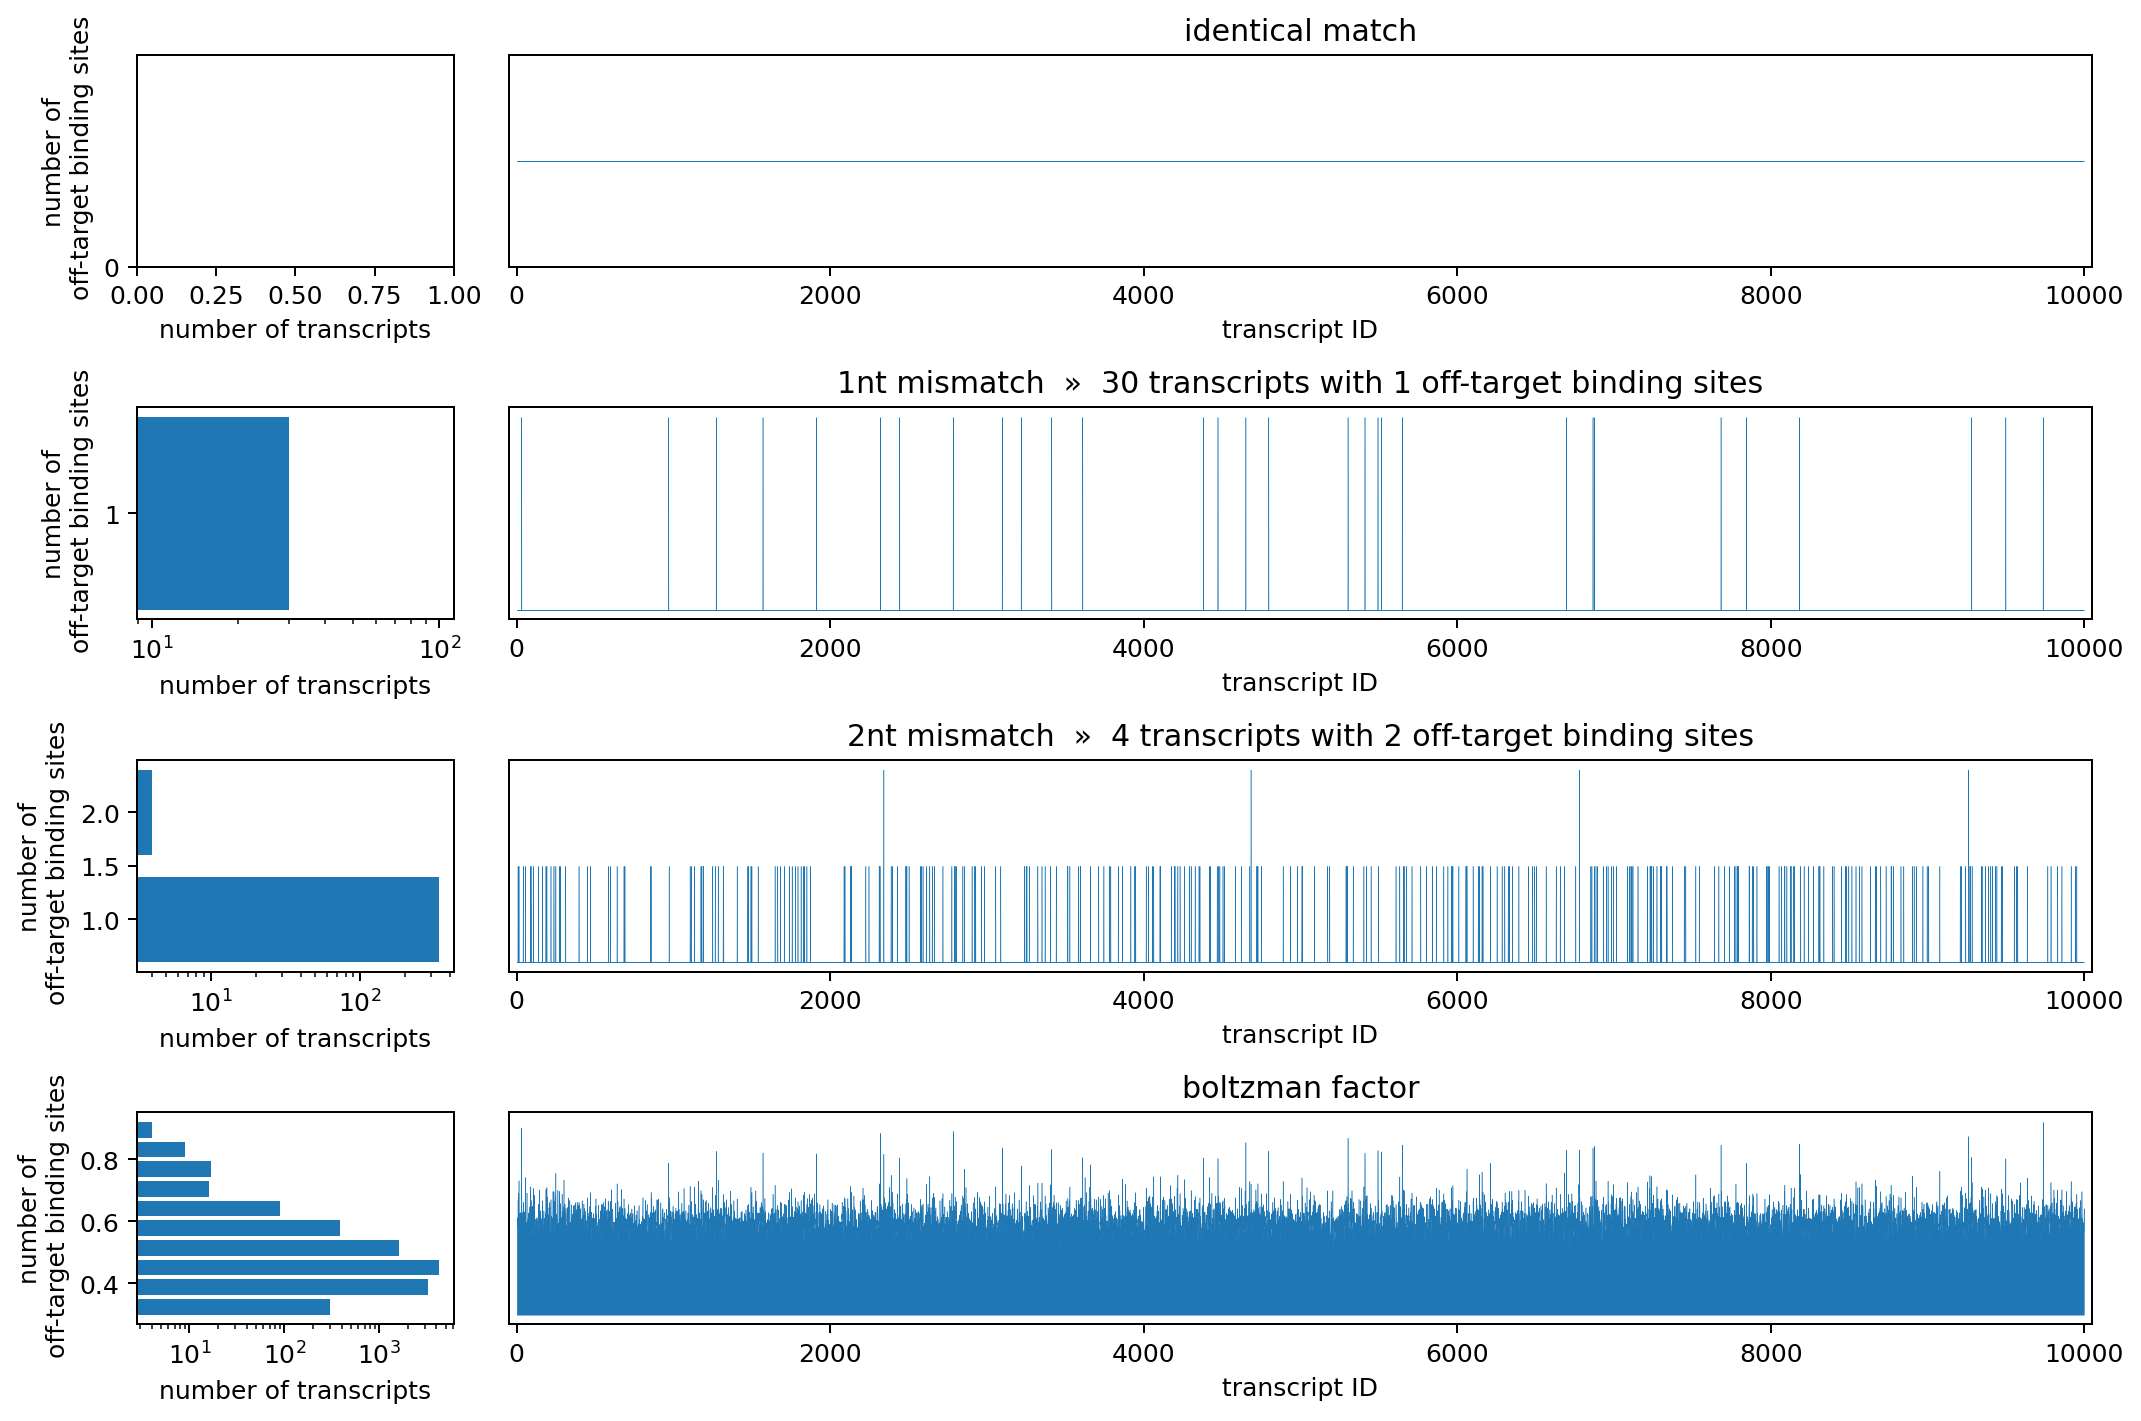

In [7]:
### summarize interaction of query with reference dataset      
# now that we have a huge and detailed list of the interaction with every of the thousands of reference sequences (i.e. transcripts), we need to summarize again to only a few metrics telling how much this query sequence interacts with the references overall
query_summary = {"SEQUENCE": query.SEQUENCE}
if plot: fig, ax = plt.subplots(len(detailed_query_results.columns)-1, 2, figsize = (12, 8), gridspec_kw={'width_ratios': [1, 5]}, dpi = 180)
    
for i, col in enumerate(detailed_query_results.drop("SEQ_NAME", axis = 1).columns): # iterate over all the metrics that should be summarized
    metric = detailed_query_results[col]
    e = 100
    query_summary[metric.name+f"_max"] = metric.max()  # What was the highest number of off-target binding sites on a single transcript 
    query_summary[metric.name+f"_sum"] = metric.sum()  # What was the total number of off-target binding sites on the whole transcriptome
    query_summary[metric.name+f"_score{e}"] = np.emath.logn(e, np.sum(e**(metric/e))) - 1.5 # something inbetween max and sum, its a weighted sum where 100 trancripts with one binding site are worth as much as one transcript with two binding sites.  This penelizes outliers with a high number of binding sites on a single transcript, while still containing the information of all other transcripts as well. The e = 100 was chosen arbitrarily, there likly is a better way of weighting all this
    insert = "" # for plotting labels
    if plot:
        if metric.max() > 0 and i < 3: # i.e. if there are mismatches to plot. i==3 is pseudo prob and metric.max() <= 0 is no mismatches
            insert = f"  »  {(metric == metric.max()).sum()} transcripts with {metric.max()} off-target binding sites"
            ax[i,0].hist(metric, log = True, range = (0.5, metric.max()+0.5), bins = np.ceil(metric.max()).astype(int), orientation='horizontal', rwidth = .8) # ignore the 0 mismatch per transcript bin, it might be to large
            if  metric.max() == 1: # with at most one mistmatch per transcript, the histogram has only one bar
                ax[i,0].set_yticks([1])
        elif i==3:
            ax[i,0].hist(metric, log = True, orientation='horizontal', rwidth = .8) # plot predicted binding pseudo probability (not normalized, i.e. arbitrary units)
        else:
            ax[i,0].set_yticks([0])
            
        ax[i,1].fill_between(np.arange(len(metric)), np.zeros(len(metric)), metric, ec = "tab:blue", fc = "tab:blue", lw = 0.2, alpha = 1)
        ax[i,0].set_xlabel("number of transcripts")
        ax[i,0].set_ylabel("number of\n off-target binding sites")
        ax[i,1].set_xlabel("transcript ID")
        ax[i,1].set_xlim(-len(metric)*0.005, len(metric)*1.005)
        ax[i,1].set_title(metric.name + insert)
        ax[i,1].set_yticks([])
        plt.tight_layout()
query_summary

{'SEQUENCE': 'CTCTGTTTAATC',
 'identical match_max': np.int64(0),
 'identical match_sum': np.int64(0),
 'identical match_score100': np.float64(0.5),
 '1nt mismatch_max': np.int64(1),
 '1nt mismatch_sum': np.int64(30),
 '1nt mismatch_score100': np.float64(0.5000306993323664),
 '2nt mismatch_max': np.int64(2),
 '2nt mismatch_sum': np.int64(348),
 '2nt mismatch_score100': np.float64(0.5003560383089143),
 'boltzman factor_max': np.float16(0.9263),
 'boltzman factor_sum': np.float16(4430.0),
 'boltzman factor_score100': np.float64(0.5052190531626706)}

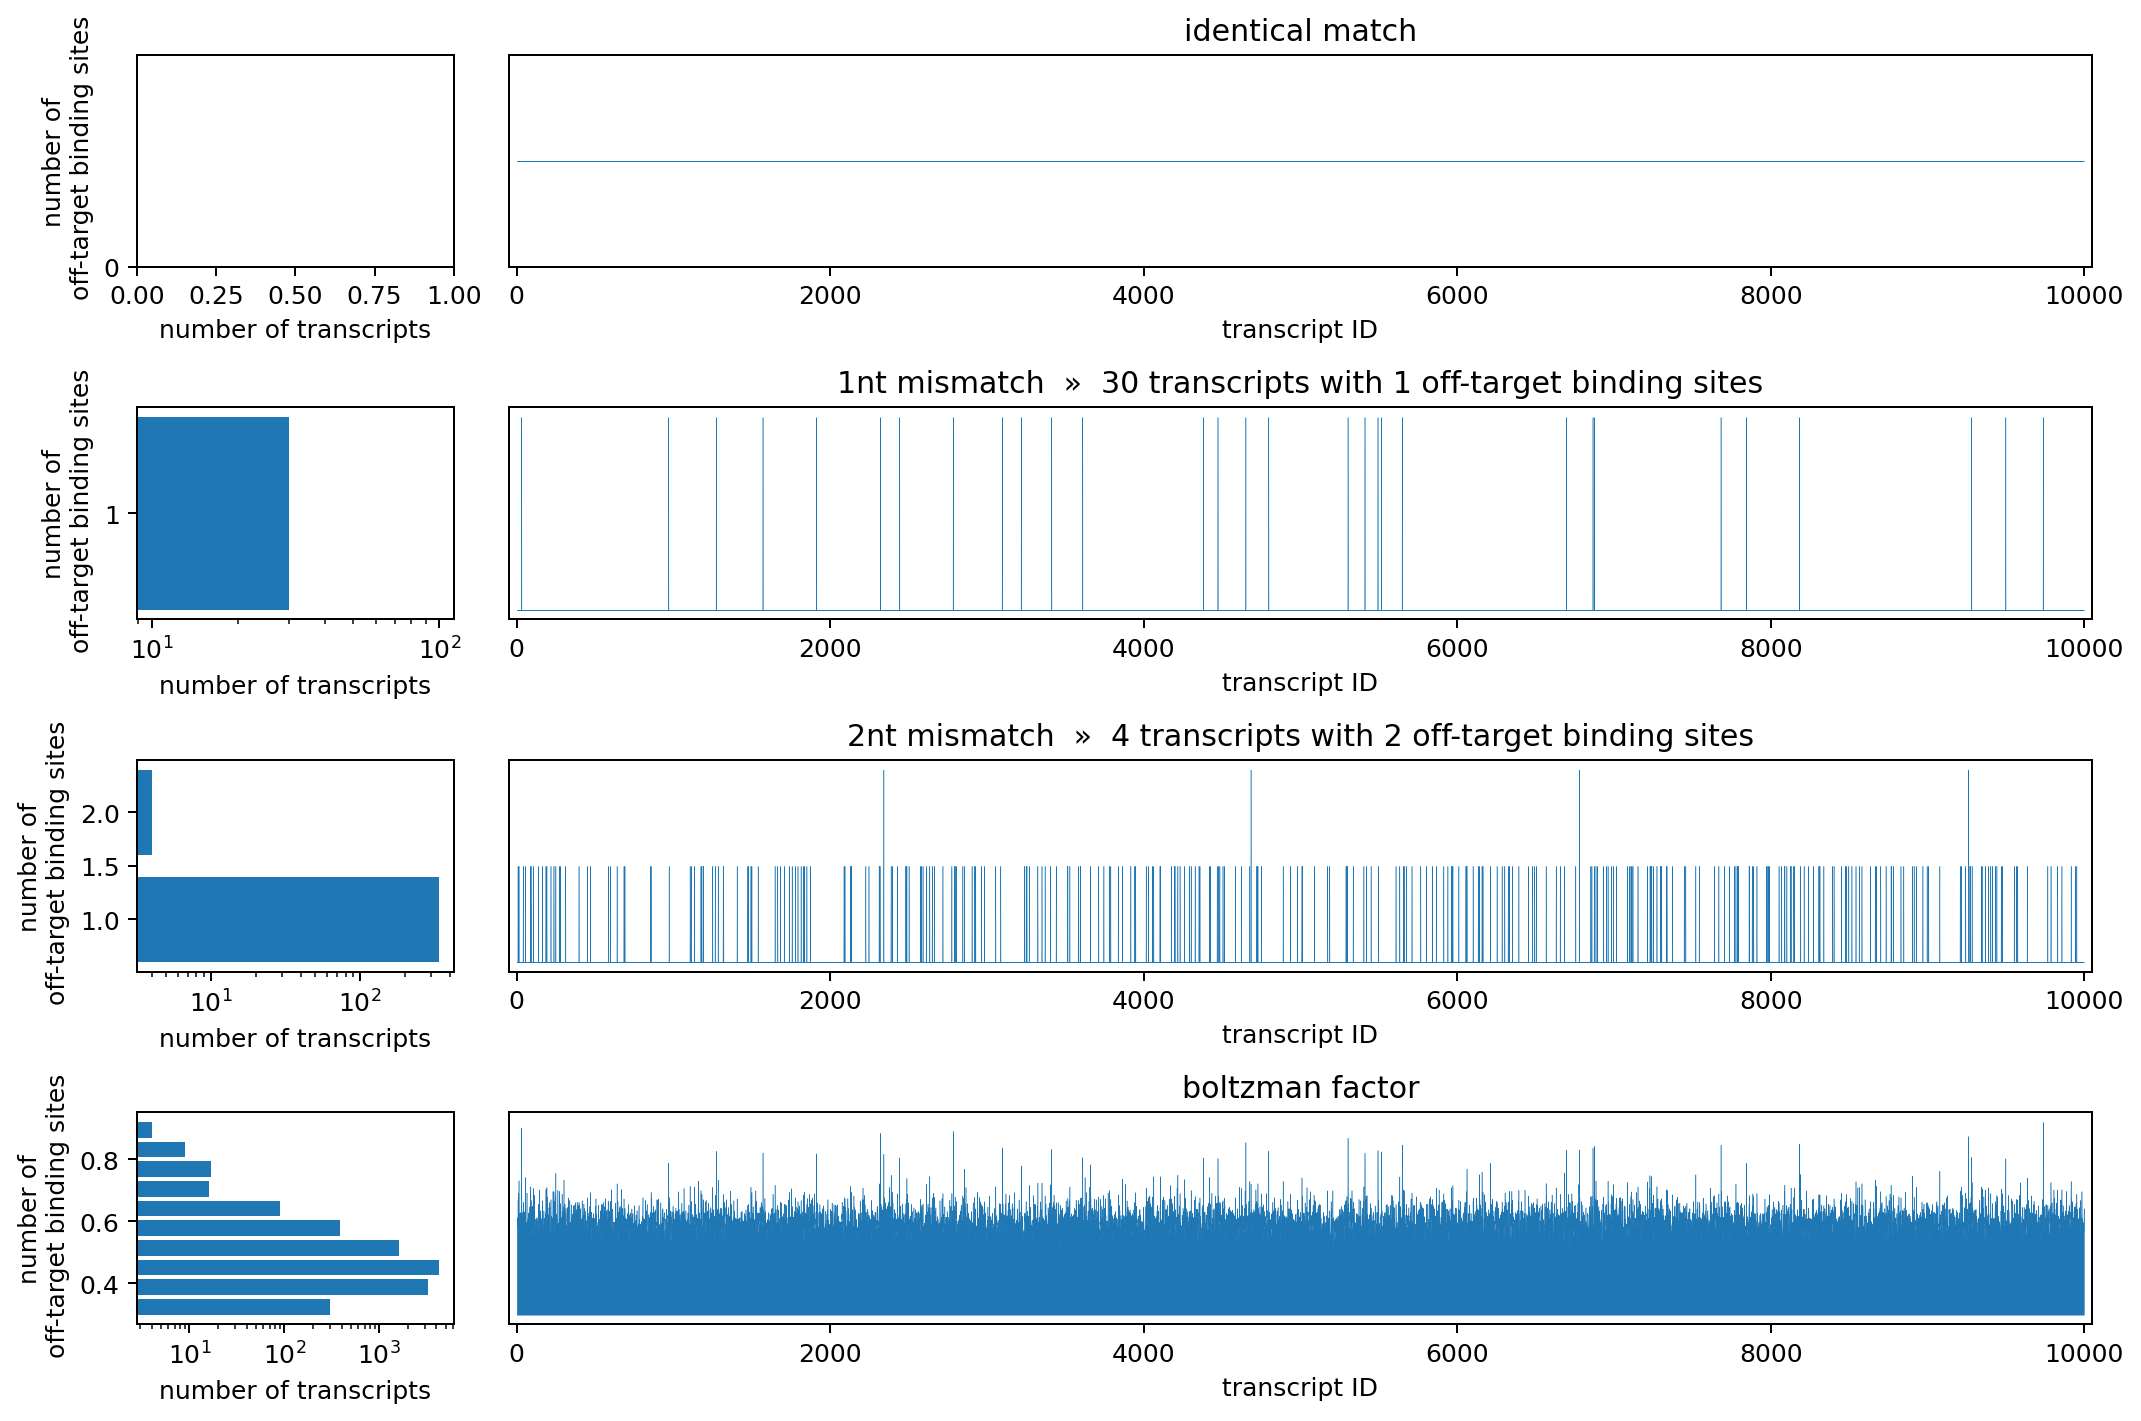

In [8]:
def query_eval(query, reference_dataset, plot = False):
    '''searches for (partial) matches between query sequence and reference dataset
    query: sequence to be found (pd.Series object)
    reference_dataset: pd.DataFrame of sequences to test against
    Both need at least a SEQ_NAME and a SEQUENCE column
    '''

    if type(query) == str:
        print("Warning, deprecated input type for query")
        query = pd.Series({"SEQ_NAME": "unnamed", "SEQUENCE": query})
    
    #-------------------------------------------------#
    #  Search for binding sites in reference dataset  #
    #-------------------------------------------------#
    
    detailed_query_results = pd.DataFrame()                    # initialize a dataset to store the results of comparing query sequence with every reference i.e. every transcript in the transcriptome
    for i, ref in reference_dataset.iterrows():                # iterate over all reference sequences. 
        
        mm = len(query.SEQUENCE)-sc_jit(query.SEQUENCE.encode("utf-8"), ref.SEQUENCE.encode("utf-8")) # number of mismatches per position # utf8 encoding of strings to integers speeds up the comparison for some reason
        sc_row = {"SEQ_NAME": ref.SEQ_NAME}                    # summarize the possible binding sites of the query sequence against one reference sequence i.e. a transcript from the transcriptome
        sc_row["identical match"] = (mm==0).sum()              # number of idential matches
        sc_row["1nt mismatch"]    = (mm==1).sum()              # number of sites with 1 mismatch
        sc_row["2nt mismatch"]    = (mm==2).sum()              # number of sites with 2 mistmatches
        sc_row["boltzman factor"] = np.sum(np.exp(-mm))        # a prediction of how likely the query sequence would bind to the reference. Currently the boltzman_factor for a perfect match is 1, if therefore this predicted boltzman_factor is smaller than 1 than it is more likly to bind to the specific RNA, while if it is larger than one it is more likely to bind to the background transcriptom ""
        
        detailed_query_results = pd.concat([detailed_query_results, pd.DataFrame([sc_row])], ignore_index=True) # add the results for this transcript to the dataset

    #-------------------------------------------------------#
    # summarize interaction of query with reference dataset #       # now that we have a huge and detailed list of the interaction with every of the thousands of reference sequences (i.e. transcripts), we need to summarize again to only a few metrics telling how much this query sequence interacts with the references overall
    #-------------------------------------------------------#

    query_summary = {"SEQUENCE": query.SEQUENCE}
    if plot: fig, ax = plt.subplots(len(detailed_query_results.columns)-1, 2, figsize = (12, 8), gridspec_kw={'width_ratios': [1, 5]}, dpi = 180)
        
    for i, col in enumerate(detailed_query_results.drop("SEQ_NAME", axis = 1).columns): # iterate over all the metrics that should be summarized
        metric = detailed_query_results[col]
        e = 100
        query_summary[metric.name+f"_max"] = metric.max()  # What was the highest number of off-target binding sites on a single transcript 
        query_summary[metric.name+f"_sum"] = metric.sum()  # What was the total number of off-target binding sites on the whole transcriptome
        query_summary[metric.name+f"_score{e}"] = np.emath.logn(e, np.sum(e**(metric/e))) - 1.5 # something inbetween max and sum, its a weighted sum where 100 trancripts with one binding site are worth as much as one transcript with two binding sites.  This penelizes outliers with a high number of binding sites on a single transcript, while still containing the information of all other transcripts as well. The e = 100 was chosen arbitrarily, there likly is a better way of weighting all this
        insert = "" # for plotting labels
        if plot:
            if metric.max() > 0 and i < 3: # i.e. if there are mismatches to plot. i==3 is pseudo prob and metric.max() <= 0 is no mismatches
                insert = f"  »  {(metric == metric.max()).sum()} transcripts with {metric.max()} off-target binding sites"
                ax[i,0].hist(metric, log = True, range = (0.5, metric.max()+0.5), bins = np.ceil(metric.max()).astype(int), orientation='horizontal', rwidth = .8) # ignore the 0 mismatch per transcript bin, it might be to large
                if  metric.max() == 1: # with at most one mistmatch per transcript, the histogram has only one bar
                    ax[i,0].set_yticks([1])
            elif i==3:
                ax[i,0].hist(metric, log = True, orientation='horizontal', rwidth = .8) # plot predicted binding pseudo probability (not normalized, i.e. arbitrary units)
            else:
                ax[i,0].set_yticks([0])
                
            ax[i,1].fill_between(np.arange(len(metric)), np.zeros(len(metric)), metric, ec = "tab:blue", fc = "tab:blue", lw = 0.2, alpha = 1)
            ax[i,0].set_xlabel("number of transcripts")
            ax[i,0].set_ylabel("number of\n off-target binding sites")
            ax[i,1].set_xlabel("transcript ID")
            ax[i,1].set_xlim(-len(metric)*0.005, len(metric)*1.005)
            ax[i,1].set_title(metric.name + insert)
            ax[i,1].set_yticks([])
            plt.tight_layout()
    
    return query_summary


query_eval(query, reference_dataset, plot = plot)


# Now query all possible candidate sequences from the target (in parallel)


In [9]:
target_sequence   = pd.Series(    {"SEQ_NAME": "random_target",           "SEQUENCE": random_seq(size = 800)})                             #  Binding Site Candidate
reference_dataset = pd.DataFrame([{"SEQ_NAME": f"random_transcript_#{i}", "SEQUENCE": random_seq(size = 10**3)} for i in range(10000)])    # The reference to check against, i.e. a transcript from the transcriptome in this example
binding_site_len = 12  # length of the pumby binding sites
plot = True

query_dataset = pd.DataFrame([{"SEQ_NAME": target_sequence.SEQ_NAME + f"_{k}:{k+binding_site_len}", "SEQUENCE":target_sequence.SEQUENCE[k:k+binding_site_len]} for k in range(len(target_sequence.SEQUENCE)-binding_site_len)] )
query_dataset

,SEQ_NAME,SEQUENCE
0,random_target_0:12,ACTTTTTTTAGG
1,random_target_1:13,CTTTTTTTAGGC
2,random_target_2:14,TTTTTTTAGGCC
3,random_target_3:15,TTTTTTAGGCCA
4,random_target_4:16,TTTTTAGGCCAA
...,...,...
783,random_target_783:795,GGTCCTTCGCTG
784,random_target_784:796,GTCCTTCGCTGC
785,random_target_785:797,TCCTTCGCTGCA
786,random_target_786:798,CCTTCGCTGCAG


In [10]:
#-------------------------------#
#  Parallel processing: joblib  #  
#-------------------------------#          # using joblib instead of multiprocessing becasue of windows compatibility
from joblib import Parallel, delayed
from tqdm import tqdm
scores = list(Parallel(n_jobs=-1)(delayed(query_eval)(query, reference_dataset) for row_ID, query in tqdm(query_dataset.iterrows(), total=len(query_dataset), ncols = 100)))

100%|█████████████████████████████████████████████████████████████| 788/788 [04:26<00:00,  2.95it/s]


# Visualize results

In [12]:
df = pd.DataFrame(scores)
df

C:\Users\T3D\miniforge3\lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,SEQUENCE,identical match_max,identical match_sum,identical match_score100,1nt mismatch_max,1nt mismatch_sum,1nt mismatch_score100,2nt mismatch_max,2nt mismatch_sum,2nt mismatch_score100,boltzman factor_max,boltzman factor_sum,boltzman factor_score100
0,ACTTTTTTTAGG,1,2,0.500002,1,18,0.500018,3,371,0.500380,1.471680,4420.0,0.505219
1,CTTTTTTTAGGC,1,1,0.500001,1,24,0.500025,2,354,0.500362,1.488281,4420.0,0.505219
2,TTTTTTTAGGCC,0,0,0.500000,1,21,0.500021,2,345,0.500353,1.031250,4416.0,0.505219
3,TTTTTTAGGCCA,0,0,0.500000,1,21,0.500021,2,365,0.500373,0.903320,4420.0,0.505219
4,TTTTTAGGCCAA,1,1,0.500001,1,12,0.500012,2,367,0.500376,1.392578,4424.0,0.505219
...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,GGTCCTTCGCTG,0,0,0.500000,1,15,0.500015,3,347,0.500355,0.965332,4424.0,0.505219
784,GTCCTTCGCTGC,0,0,0.500000,1,16,0.500016,2,376,0.500385,0.935547,4420.0,0.505219
785,TCCTTCGCTGCA,1,1,0.500001,1,17,0.500017,2,351,0.500359,1.396484,4424.0,0.505219
786,CCTTCGCTGCAG,1,1,0.500001,1,22,0.500023,2,350,0.500358,1.463867,4424.0,0.505219


In [11]:

## Visualize the the offtarget binding sites for every candidate sequence ## 

df = pd.DataFrame(scores)
col = f'mismatch_eq'
for _mm in range(0, 3):

    col1 = col + f'_{_mm}_sum'
    col2 = col + f'_{_mm}_max'
    sel = df[df[col1]<0.5]
    plt.figure(figsize = (20, 3))

    if _mm == 0: insert = "identical"
    else:        insert = f"{_mm}-mismatch"

    sx = np.round(0.66 * df[col1].mean() / df[col2].mean(), 0).astype(int)
    plt.bar(df.index,  df[col1].values, label = "total number in transcriptome")
    plt.bar(df.index, -df[col2].values*sx,  label = "max number per transcript")
    if len(sel) > 0:
        plt.bar(sel.index, .02*df[col2].max(), bottom = -.01*df[col2].max(), label = f"no {insert} off-target binding sites in any transcript", color = "black")
    plt.xlabel("target candidates")
    plt.ylabel(f"number of {insert} \n off-target binding sites");
    yl = plt.yticks()[0]
    yl[yl<0] /= sx
    yl = np.unique(yl.round().astype(int))
    yt = yl.copy()
    yt[yt<0] *= sx
    plt.yticks(yt, np.abs(yl))
    plt.legend();

    if len(sel) == 0:
        plt.title(f"no candidate without {insert} off-target binding sites found")
        plt.show()

    else: 
        df = sel.reset_index(drop = _mm > 0)  # select only those with fewest number of offtarget binding sites
        plt.title(f"{len(sel)} candidate without {insert} off-target binding sites found")
    plt.show()
select = df.copy()
print(f"continue with {len(select)} candidates")

KeyError: 'mismatch_eq_0_sum'

In [ ]:
## Rank remaining sequences based on obtained metrics

select["rank_max"] = 0
select["rank_sum"] = 0
for col in ['mismatch_eq_0_score100', 'mismatch_eq_1_score100', 'boltzman_factor_score100', 'boltzman_factor_max', 'boltzman_factor_sum']:
    select["rank_max"] = np.max([select[col].rank(pct = True), select["rank_max"]], axis = 0)
    select["rank_sum"] += select[col].rank(pct = True)
candidates = pd.concat([select.sort_values("rank_max")[:5], select.sort_values("rank_sum")[:5]]).sort_values("boltzman_factor_max")
candidates = candidates[~candidates.index.duplicated(keep='first')]

_df = candidates.drop(["sequence", "index"], axis = 1)
mat = np.array(_df.values)
mat -= mat.mean(axis = 0)
mat /= (mat.std(axis = 0)+1e-9)
mat += 2*(mat.std(axis = 0)+1e-9)

fig = plt.figure(figsize = (8, 12))
plt.matshow(mat.T, fignum = 0)

for (i, j), z in np.ndenumerate(np.array(_df.values)):
    plt.text(i,j, '{:0.4g}'.format(z), ha='center', va='center', rotation = 20, fontsize = 10)

plt.yticks(np.arange(0, mat.shape[1]), labels = _df.columns);
plt.xticks(np.arange(0, mat.shape[0]), labels = _df.index);
plt.show()

for i, row in candidates.iterrows():
    print("\n" + "-"*100)
    print(row)
    search_target_in_refpool(row["sequence"], transcriptom, plot = True)
    plt.show()